In [6]:
import torch
import numpy as np
from torch.utils.data import Dataset, ConcatDataset
from PIL import Image
import os
from torchvision import transforms

class WeldingDefectDataset(torch.utils.data.Dataset):
    def __init__(self, datasets_dirs, transform=None):
        self.datasets_dirs = datasets_dirs  # List of dataset directories
        self.image_files = []
        self.transform = transform

        # Collect all image and label files from the provided directories
        for dataset_dir in datasets_dirs:
            images_dir = os.path.join(dataset_dir, 'images')
            labels_dir = os.path.join(dataset_dir, 'labels')

            if os.path.exists(images_dir) and os.path.exists(labels_dir):
                image_files = os.listdir(images_dir)
                self.image_files.extend([(os.path.join(images_dir, img), os.path.join(labels_dir, img.replace('.jpg', '.txt').replace('.jpeg', '.txt').replace('.png', '.txt'))) for img in image_files])

    def __getitem__(self, idx):
        image_path, label_path = self.image_files[idx]

        # Check if image file exists
        if not os.path.exists(image_path):
            return self.__getitem__((idx + 1) % len(self.image_files))  # Recursively try the next item

        # Load the image
        image = Image.open(image_path).convert('RGB')  # Or 'L' for grayscale

        # Make sure the label file exists
        if not os.path.exists(label_path):
            raise FileNotFoundError(f"Label not found: {label_path}")

        label = self.load_label(label_path)  # Load the label

        if self.transform:
            image = self.transform(image)

        return image, label

    def load_label(self, label_path):
        with open(label_path, 'r') as file:
            # Read the first line and split into parts
            label_data = file.readline().strip().split()

            # Extract the class ID and convert class 2 to 1 for binary classification
            class_id = int(label_data[0])
            if class_id == 2:
                class_id = 1  # Convert class 2 to 1 for binary classification

            return class_id

    def __len__(self):
        # Return the number of images in the dataset
        return len(self.image_files)

# Found them seperately using compute 
mean = [0.5027, 0.4904, 0.4793]
std = [0.2606, 0.2597, 0.2607]
# Define your transformations (resize and normalization)
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define base paths for both dataset versions
base_path_v1 = 'C:/Users/nani0/Desktop/WeldingDefectDetection/DataSet/TheWeldingDefectDataset-v1'
base_path_v2 = 'C:/Users/nani0/Desktop/WeldingDefectDetection/DataSet/TheWeldingDefectDataset-v2'

# Define your datasets for training, validation, and testing
train_dataset_v1 = WeldingDefectDataset(
    datasets_dirs=[os.path.join(base_path_v1, 'train')],
    transform=transform
)

train_dataset_v2 = WeldingDefectDataset(
    datasets_dirs=[os.path.join(base_path_v2, 'train')],
    transform=transform
)

valid_dataset_v1 = WeldingDefectDataset(
    datasets_dirs=[os.path.join(base_path_v1, 'valid')],
    transform=transform
)

valid_dataset_v2 = WeldingDefectDataset(
    datasets_dirs=[os.path.join(base_path_v2, 'valid')],
    transform=transform
)

test_dataset_v1 = WeldingDefectDataset(
    datasets_dirs=[os.path.join(base_path_v1, 'test')],
    transform=transform
)

test_dataset_v2 = WeldingDefectDataset(
    datasets_dirs=[os.path.join(base_path_v2, 'test')],
    transform=transform
)

# Combine datasets
train_dataset = ConcatDataset([train_dataset_v1, train_dataset_v2])
valid_dataset = ConcatDataset([valid_dataset_v1, valid_dataset_v2])
test_dataset = ConcatDataset([test_dataset_v1, test_dataset_v2])

# DataLoader for batching and shuffling
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..0.6705013].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6109256..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.2855553..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4671633..2.5005665].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5870366..2.3088455].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.2282355].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..1.923538]

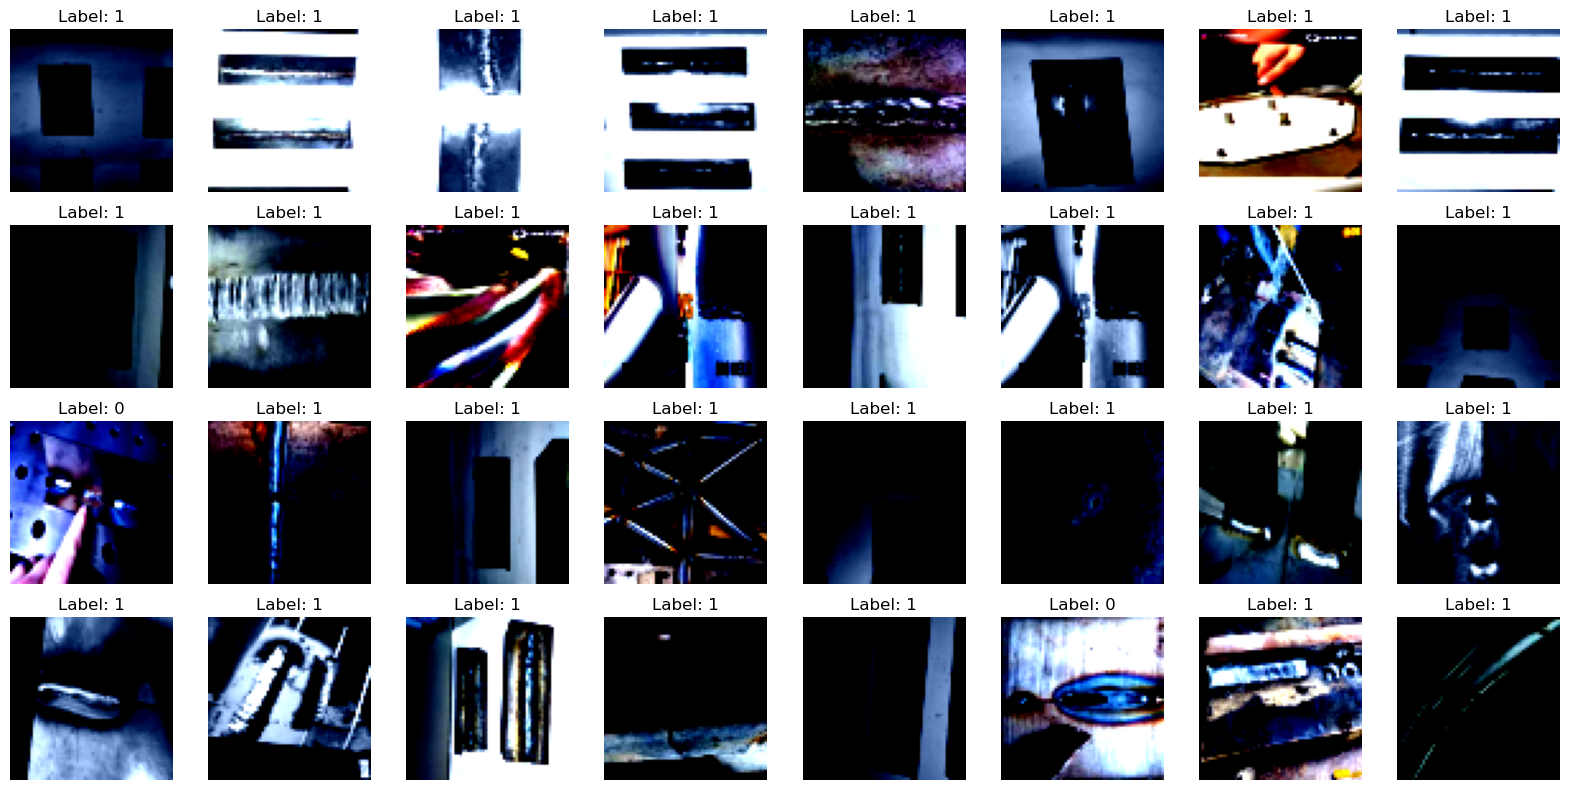

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(images, labels, batch_size=32):
    # Convert tensor to numpy array
    images = images.numpy().transpose((0, 2, 3, 1))  # Change shape from (batch_size, 3, 64, 64) to (batch_size, 64, 64, 3)
    
    # Set up the plot with the correct number of images
    # For batch_size 32, we'll show 8 images per row
    rows = 4  # Adjust this depending on the number of images per row
    cols = 8  # Adjust this depending on the batch size and number of images per row
    fig, axes = plt.subplots(rows, cols, figsize=(16, 8))  # Adjust the figure size accordingly
    
    # Loop through the batch and plot each image
    for i in range(batch_size):
        ax = axes[i // cols, i % cols]  # Determine the position of the image in the grid
        ax.imshow(images[i])  # Show the image
        ax.set_title(f"Label: {labels[i].item()}")  # Display label below the image
        ax.axis('off')  # Hide axes
    
    plt.tight_layout()
    plt.show()


# Get the first batch
images, labels = next(iter(train_loader))

# Plot the first batch
imshow(images, labels, batch_size=32)


In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiScaleCNN(nn.Module):
    def __init__(self):
        super(MultiScaleCNN, self).__init__()

        # First shared convolutional layer
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)  # Common initial layer
        self.bn1 = nn.BatchNorm2d(16)

        # Multi-scale feature extraction
        self.conv2_small = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)  # Small receptive field
        self.bn2_small = nn.BatchNorm2d(32)
        
        self.conv2_medium = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2)  # Medium receptive field
        self.bn2_medium = nn.BatchNorm2d(32)
        
        self.conv2_large = nn.Conv2d(16, 32, kernel_size=7, stride=1, padding=3)  # Large receptive field
        self.bn2_large = nn.BatchNorm2d(32)

        # Combine multi-scale features and process further
        self.conv3 = nn.Conv2d(96, 64, kernel_size=3, stride=1, padding=1)  # Combine features from all scales
        self.bn3 = nn.BatchNorm2d(64)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Dropout to prevent overfitting
        self.dropout = nn.Dropout(0.5)

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 16 * 16, 256)  # Adjusted based on tensor size after pooling
        self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(256, 128)
        self.dropout = nn.Dropout(0.25)
        self.fc3 = nn.Linear(128, 1)  # Single output for binary classification

    def forward(self, x):
        # Shared initial feature extraction with BatchNorm and LeakyReLU
        x = F.leaky_relu(self.bn1(self.conv1(x)))
        x = self.pool(x)

        # Multi-scale feature extraction with BatchNorm and LeakyReLU
        small_features = F.leaky_relu(self.bn2_small(self.conv2_small(x)))  # Small receptive field
        medium_features = F.leaky_relu(self.bn2_medium(self.conv2_medium(x)))  # Medium receptive field
        large_features = F.leaky_relu(self.bn2_large(self.conv2_large(x)))  # Large receptive field

        # Concatenate features from all scales
        x = torch.cat((small_features, medium_features, large_features), dim=1)

        # Further processing with convolutional layer and BatchNorm
        x = F.leaky_relu(self.bn3(self.conv3(x)))
        x = self.pool(x)

        # Flatten for fully connected layers
        x = x.view(x.size(0), -1)

        # Fully connected layers with Dropout
        x = F.leaky_relu(self.fc1(x))
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x))
        x = self.fc3(x)  # No activation yet (logits)

        return x

# Initialize the model
model = MultiScaleCNN()


In [37]:
import torch.optim as optim
# Optimizer and Loss function for binary classification
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.BCEWithLogitsLoss()  # Correct loss function for binary classification with logits


In [38]:
import torch
import torch.nn as nn
import torch.optim as optim

def train_or_validate_model(model, data_loader, criterion, optimizer=None, is_training=True):
    # Set the model to train or evaluation mode
    if is_training:
        model.train()
    else:
        model.eval()

    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    # Lists to store ground truth and predictions
    ground_truth = []
    predicted_truth = []

    # Disable gradient computation during validation (for memory efficiency)
    with torch.set_grad_enabled(is_training):
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)

            # Zero the parameter gradients
            if is_training:
                optimizer.zero_grad()

            # Forward pass
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels.float())

            # Backpropagation and optimization step (only during training)
            if is_training:
                loss.backward()
                optimizer.step()

            # Calculate predictions
            predicted = (outputs > 0.5).float()

            # Collect ground truth and predictions for the entire dataset
            ground_truth.extend(labels.cpu().tolist())
            predicted_truth.extend(predicted.cpu().tolist())

            # Update metrics
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

            running_loss += loss.item()

    # Calculate the average loss and accuracy for this epoch
    avg_loss = running_loss / len(data_loader)
    accuracy = 100 * correct_predictions / total_predictions

    return avg_loss, accuracy, ground_truth, predicted_truth


# Function to train and validate the model with early stopping and best model saving
def train_and_validate_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=50):
    best_val_acc = 0.0
    best_model_weights = None

    # Initialize lists to store metrics
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    # Initialize lists for ground truth and predictions
    train_ground_truth = []
    train_predicted_truth = []
    val_ground_truth = []
    val_predicted_truth = []

    for epoch in range(num_epochs):
        # Training phase
        avg_train_loss, train_accuracy, train_labels, train_predictions = train_or_validate_model(
            model, train_loader, criterion, optimizer, is_training=True
        )
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

        # Validation phase (after each epoch of training)
        avg_val_loss, val_accuracy, val_labels, val_predictions = train_or_validate_model(
            model, valid_loader, criterion, is_training=False
        )
        print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

        # Save the best model weights based on validation accuracy
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            best_model_weights = model.state_dict()
            torch.save(best_model_weights, 'best_model_new.pth')

        # Append the results of this epoch to the lists
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        # Store ground truth and predictions
        train_ground_truth.extend(train_labels)
        train_predicted_truth.extend(train_predictions)
        val_ground_truth.extend(val_labels)
        val_predicted_truth.extend(val_predictions)

    # Load the best weights after training
    model.load_state_dict(best_model_weights)
    print(f"Training complete. Best validation accuracy: {best_val_acc:.4f}")

    return {
        "train_losses": train_losses,
        "train_accuracies": train_accuracies,
        "val_losses": val_losses,
        "val_accuracies": val_accuracies,
        "best_val_acc": best_val_acc,
        "train_ground_truth": train_ground_truth,
        "train_predicted_truth": train_predicted_truth,
        "val_ground_truth": val_ground_truth,
        "val_predicted_truth": val_predicted_truth,
    }

# Ensure the device setup is done before calling the train function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move model to the correct device

# Training the model with validation and best weights saving
results = train_and_validate_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=50)

# Now, 'results' contains all the required data
train_losses = results["train_losses"]
train_accuracies = results["train_accuracies"]
val_losses = results["val_losses"]
val_accuracies = results["val_accuracies"]
best_val_acc = results["best_val_acc"]
train_ground_truth = results["train_ground_truth"]
train_predicted_truth = results["train_predicted_truth"]
val_ground_truth = results["val_ground_truth"]
val_predicted_truth = results["val_predicted_truth"]



Epoch [1/50], Train Loss: 0.4331, Train Accuracy: 78.64%
Validation Loss: 0.4545, Validation Accuracy: 77.78%
Epoch [2/50], Train Loss: 0.3383, Train Accuracy: 83.03%
Validation Loss: 0.4371, Validation Accuracy: 81.48%
Epoch [3/50], Train Loss: 0.3027, Train Accuracy: 85.23%
Validation Loss: 0.3928, Validation Accuracy: 82.57%
Epoch [4/50], Train Loss: 0.2683, Train Accuracy: 86.57%
Validation Loss: 0.3969, Validation Accuracy: 83.66%
Epoch [5/50], Train Loss: 0.2192, Train Accuracy: 90.28%
Validation Loss: 0.4756, Validation Accuracy: 85.40%
Epoch [6/50], Train Loss: 0.1832, Train Accuracy: 91.54%
Validation Loss: 0.3312, Validation Accuracy: 89.11%
Epoch [7/50], Train Loss: 0.1571, Train Accuracy: 93.08%
Validation Loss: 0.2981, Validation Accuracy: 89.76%
Epoch [8/50], Train Loss: 0.1457, Train Accuracy: 93.49%
Validation Loss: 0.2767, Validation Accuracy: 88.67%
Epoch [9/50], Train Loss: 0.1294, Train Accuracy: 94.75%
Validation Loss: 0.6321, Validation Accuracy: 85.62%
Epoch [10/

In [45]:
def test_model(model, test_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    correct_predictions_test = 0
    total_predictions_test = 0
    running_loss_test = 0.0
    all_labels = []
    all_predictions = []
    all_probs = []

    with torch.no_grad():  # No gradients needed for testing
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to device

            # Forward pass
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels.float())  # Ensure labels are float for BCEWithLogitsLoss

            # Apply threshold for binary classification
            probs = torch.sigmoid(outputs)  # Convert logits to probabilities
            predicted = (probs > 0.5).float()

            # Collect data for analysis and visualization
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

            # Calculate test accuracy
            correct_predictions_test += (predicted == labels).sum().item()
            total_predictions_test += labels.size(0)

            running_loss_test += loss.item()

    # Calculate final test accuracy
    accuracy_test = 100 * correct_predictions_test / total_predictions_test

    # Calculate average loss over all test samples
    avg_loss_test = running_loss_test / len(test_loader.dataset)

    return {
        "test_loss": avg_loss_test,
        "test_accuracy": accuracy_test,
        "labels": all_labels,
        "predictions": all_predictions,
        "probabilities": all_probs,
    }




In [47]:
model = MultiScaleCNN()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.load_state_dict(torch.load('best_model_new.pth'))

C:\Users\nani0\AppData\Local\Temp\ipykernel_71568\3338153761.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_new.pth'))


<All keys matched successfully>

In [48]:
# Ensure device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Call the test function
test_results = test_model(model, test_loader, criterion, device)

# Print test metrics
print(f"Test Loss: {test_results['test_loss']:.4f}")
print(f"Test Accuracy: {test_results['test_accuracy']:.2f}%")


# Access predictions and labels for further analysis or plotting
labels = test_results["labels"]
predictions = test_results["predictions"]
probabilities = test_results["probabilities"]

Test Loss: 0.0350
Test Accuracy: 88.50%


In [49]:
import torch
from torchvision import transforms
from PIL import Image

# Define the prediction function
def predict_image(model, image_path, device):
    # Set the model to evaluation mode
    model.eval()
    
    # Define the image transformation (without normalization)
    transform = transforms.Compose([
        transforms.Resize((64, 64)),  # Adjust the size if needed
        transforms.ToTensor(),  # Convert to tensor (no normalization)
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization
    ])
    
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')  # Ensure 3 channels (RGB)
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to the correct device

    # Get model prediction
    with torch.no_grad():  # No need to track gradients for inference
        output = model(image)
        predicted = (output > 0.5).float()  # Apply threshold for binary classification

    # Convert to a readable format
    prediction = "Defect" if predicted.item() == 1 else "No Defect"
    
    return prediction

# Example of usage:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_path = "C:/Users/nani0/Downloads/images.jpg"
model.to(device)  # Ensure the model is on the correct device
prediction = predict_image(model, image_path, device)
print(f"Prediction: {prediction}")


Prediction: Defect


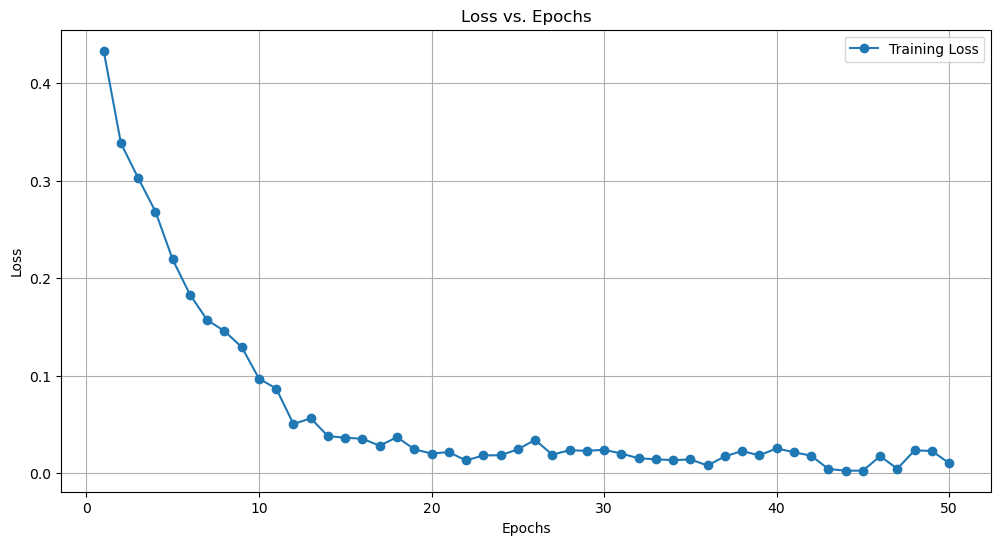

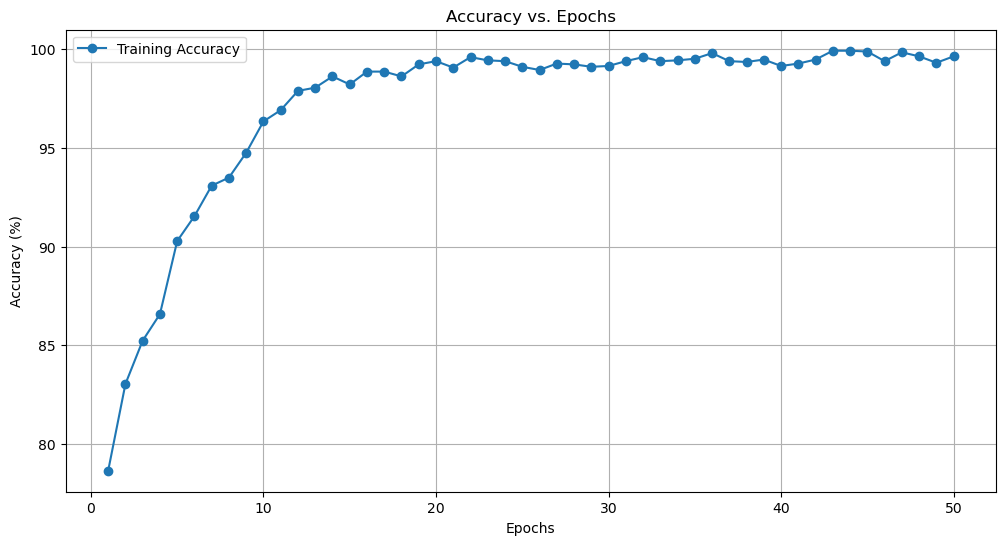

In [50]:
# Assuming the following lists contain data recorded during training:
# train_losses, train_accuracies

epochs = range(1, len(train_losses) + 1)  # Create a range for the number of epochs

# Plot Loss vs. Epochs
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_losses, label='Training Loss', marker='o')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy vs. Epochs
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy', marker='o')

plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs. Epochs')
plt.legend()
plt.grid(True)
plt.show()

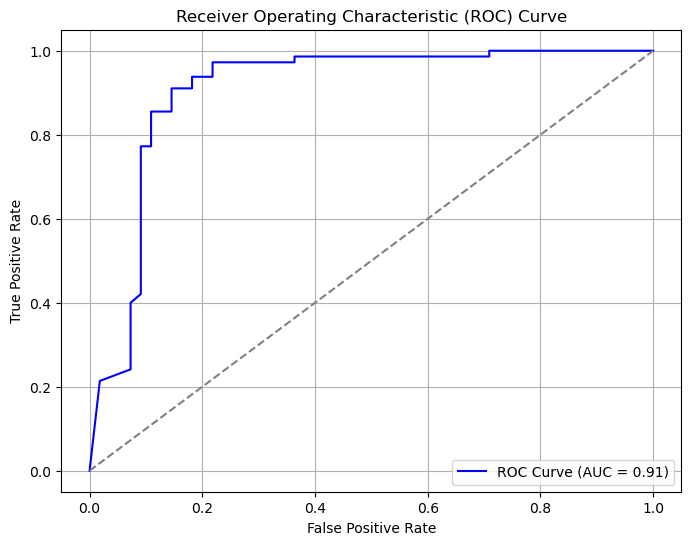

In [51]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(labels, probabilities)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


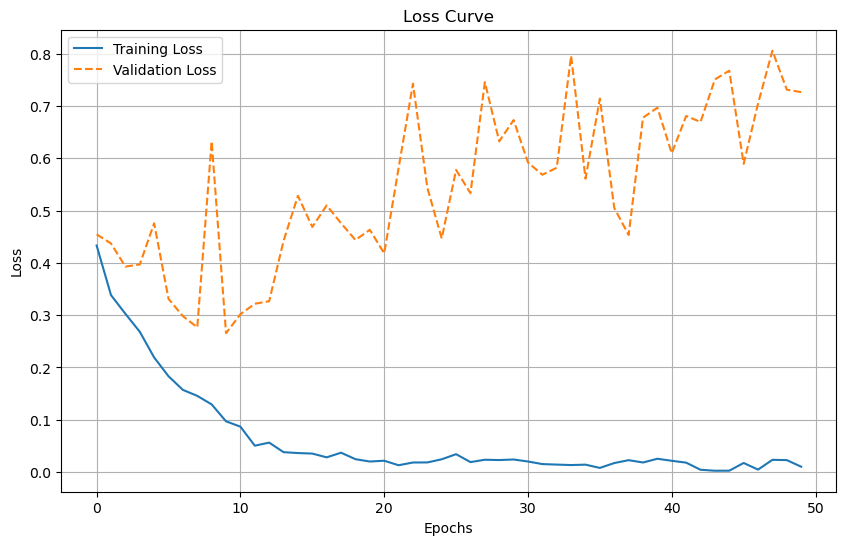

In [52]:
def plot_loss_curve(train_loss, val_loss):
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss_curve(train_losses, val_losses)

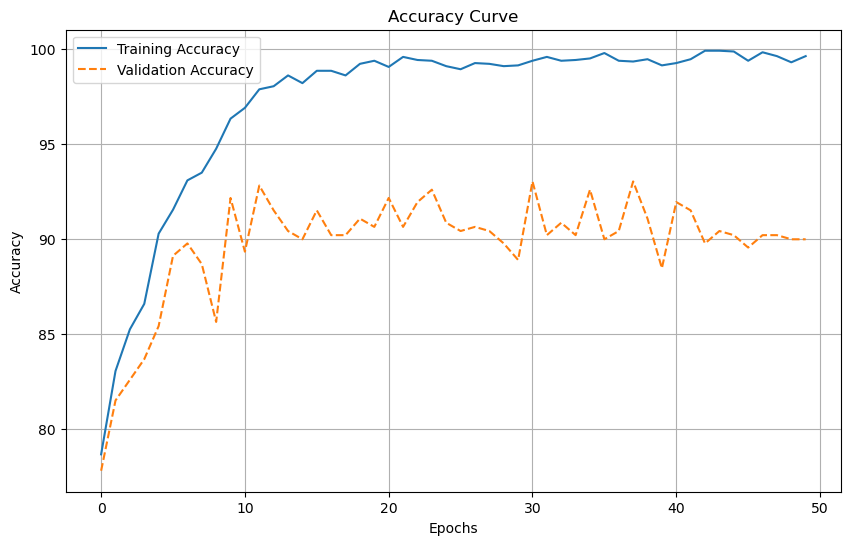

In [53]:
# 2. Accuracy Curve
def plot_accuracy_curve(train_accuracy, val_accuracy):
    plt.figure(figsize=(10, 6))
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_accuracy_curve(train_accuracies, val_accuracies)

In [77]:
train_predicted_truth = np.array(train_predicted_truth)
train_predicted_truth

array([0., 0., 0., ..., 1., 1., 1.])

In [78]:
import numpy as np

def calculate_tptnfpfn(train_ground_truth, train_predicted_truth, total_epochs):
    """
    Calculate TP, TN, FP, and FN for each epoch.

    Args:
        train_ground_truth (np.ndarray): Ground truth labels.
        train_predicted_truth (np.ndarray): Predicted labels.
        total_epochs (int): Total number of training epochs.

    Returns:
        list of dict: A list where each dict contains TP, TN, FP, and FN for an epoch.
    """
    # Debugging information
    print("Shape of train_ground_truth:", train_ground_truth.shape)
    print("Shape of train_predicted_truth:", train_predicted_truth.shape)
    print("First few ground truth values:", train_ground_truth[:10])
    print("First few predicted truth values:", train_predicted_truth[:10])

    # Ensure ground truth and predictions align
    total_images = len(train_ground_truth)
    expected_images = len(train_predicted_truth)
    print(f"Total ground truth images: {total_images}, Predicted images: {expected_images}")
    assert total_images == expected_images, "Ground truth and predictions length mismatch!"

    # Infer images per epoch
    images_per_epoch = total_images // total_epochs
    assert total_images % total_epochs == 0, "Images are not evenly distributed across epochs!"

    print(f"Inferred images per epoch: {images_per_epoch}")

    # Initialize results
    epoch_results = []

    for epoch in range(total_epochs):
        # Extract ground truth and predictions for the current epoch
        start_idx = epoch * images_per_epoch
        end_idx = start_idx + images_per_epoch

        gt_epoch = train_ground_truth[start_idx:end_idx]
        pred_epoch = train_predicted_truth[start_idx:end_idx]

        # Calculate TP, TN, FP, FN
        tp = np.sum((gt_epoch == 1) & (pred_epoch == 1))
        tn = np.sum((gt_epoch == 0) & (pred_epoch == 0))
        fp = np.sum((gt_epoch == 0) & (pred_epoch == 1))
        fn = np.sum((gt_epoch == 1) & (pred_epoch == 0))

        # Store results for the current epoch
        epoch_results.append({'TP': tp, 'TN': tn, 'FP': fp, 'FN': fn})

    return epoch_results

train_ground_truth = np.array(train_ground_truth)
train_predicted_truth = np.array(train_predicted_truth)
total_epochs = 50

# Calculate TP, TN, FP, FN for each epoch
results = calculate_tptnfpfn(train_ground_truth, train_predicted_truth, total_epochs)

# Print results
for epoch, res in enumerate(results, start=1):
    print(f"Epoch {epoch}: TP={res['TP']}, TN={res['TN']}, FP={res['FP']}, FN={res['FN']}")


Shape of train_ground_truth: (122900,)
Shape of train_predicted_truth: (122900,)
First few ground truth values: [1 1 1 1 1 1 0 1 0 1]
First few predicted truth values: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Total ground truth images: 122900, Predicted images: 122900
Inferred images per epoch: 2458
Epoch 1: TP=1802, TN=131, FP=254, FN=271
Epoch 2: TP=1874, TN=167, FP=218, FN=199
Epoch 3: TP=1884, TN=211, FP=174, FN=189
Epoch 4: TP=1890, TN=238, FP=147, FN=183
Epoch 5: TP=1937, TN=282, FP=103, FN=136
Epoch 6: TP=1937, TN=313, FP=72, FN=136
Epoch 7: TP=1969, TN=319, FP=66, FN=104
Epoch 8: TP=1982, TN=316, FP=69, FN=91
Epoch 9: TP=1998, TN=331, FP=54, FN=75
Epoch 10: TP=2017, TN=351, FP=34, FN=56
Epoch 11: TP=2036, TN=346, FP=39, FN=37
Epoch 12: TP=2042, TN=364, FP=21, FN=31
Epoch 13: TP=2049, TN=361, FP=24, FN=24
Epoch 14: TP=2055, TN=369, FP=16, FN=18
Epoch 15: TP=2045, TN=369, FP=16, FN=28
Epoch 16: TP=2058, TN=372, FP=13, FN=15
Epoch 17: TP=2061, TN=369, FP=16, FN=12
Epoch 18: TP=2053, TN=371

In [79]:
train_ground_truth = np.array(train_ground_truth)
train_predicted_truth = np.array(train_predicted_truth)

Epoch 1: Precision=0.88, Recall=0.87, F1-Score=0.87
Epoch 2: Precision=0.90, Recall=0.90, F1-Score=0.90
Epoch 3: Precision=0.92, Recall=0.91, F1-Score=0.91
Epoch 4: Precision=0.93, Recall=0.91, F1-Score=0.92
Epoch 5: Precision=0.95, Recall=0.93, F1-Score=0.94
Epoch 6: Precision=0.96, Recall=0.93, F1-Score=0.95
Epoch 7: Precision=0.97, Recall=0.95, F1-Score=0.96
Epoch 8: Precision=0.97, Recall=0.96, F1-Score=0.96
Epoch 9: Precision=0.97, Recall=0.96, F1-Score=0.97
Epoch 10: Precision=0.98, Recall=0.97, F1-Score=0.98
Epoch 11: Precision=0.98, Recall=0.98, F1-Score=0.98
Epoch 12: Precision=0.99, Recall=0.99, F1-Score=0.99
Epoch 13: Precision=0.99, Recall=0.99, F1-Score=0.99
Epoch 14: Precision=0.99, Recall=0.99, F1-Score=0.99
Epoch 15: Precision=0.99, Recall=0.99, F1-Score=0.99
Epoch 16: Precision=0.99, Recall=0.99, F1-Score=0.99
Epoch 17: Precision=0.99, Recall=0.99, F1-Score=0.99
Epoch 18: Precision=0.99, Recall=0.99, F1-Score=0.99
Epoch 19: Precision=1.00, Recall=1.00, F1-Score=1.00
Ep

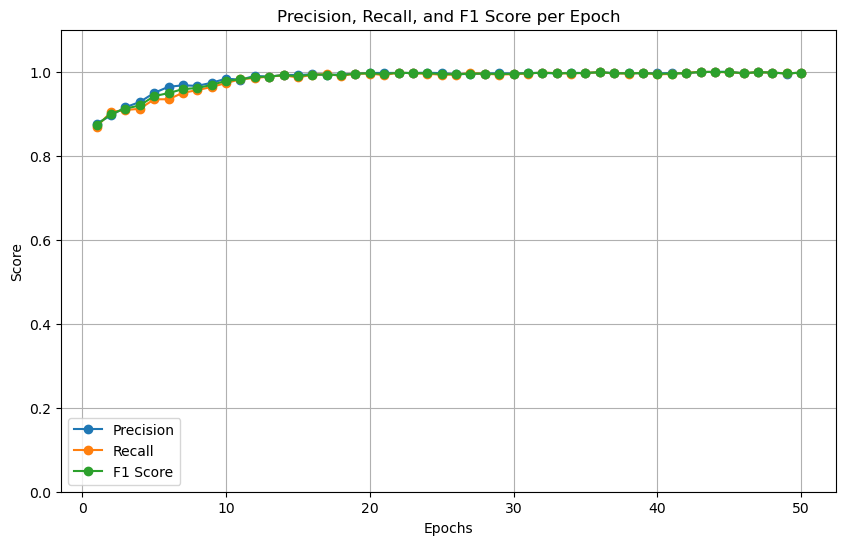

In [80]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_metrics(train_ground_truth, train_predicted_truth, total_epochs):
    """
    Calculate TP, TN, FP, FN for each epoch and derive precision, recall, F1-score.

    Args:
        train_ground_truth (np.ndarray): Ground truth labels.
        train_predicted_truth (np.ndarray): Predicted labels.
        total_epochs (int): Total number of training epochs.

    Returns:
        dict: A dictionary containing TP, TN, FP, FN, precision, recall, F1-score for each epoch.
    """
    total_images = len(train_ground_truth)
    images_per_epoch = total_images // total_epochs

    assert total_images % total_epochs == 0, "Images are not evenly distributed across epochs!"

    results = {
        'TP': [],
        'TN': [],
        'FP': [],
        'FN': [],
        'precision': [],
        'recall': [],
        'f1_score': []
    }

    for epoch in range(total_epochs):
        start_idx = epoch * images_per_epoch
        end_idx = start_idx + images_per_epoch

        gt_epoch = train_ground_truth[start_idx:end_idx]
        pred_epoch = train_predicted_truth[start_idx:end_idx]

        # Calculate TP, TN, FP, FN
        tp = np.sum((gt_epoch == 1) & (pred_epoch == 1))
        tn = np.sum((gt_epoch == 0) & (pred_epoch == 0))
        fp = np.sum((gt_epoch == 0) & (pred_epoch == 1))
        fn = np.sum((gt_epoch == 1) & (pred_epoch == 0))

        # Store TP, TN, FP, FN
        results['TP'].append(tp)
        results['TN'].append(tn)
        results['FP'].append(fp)
        results['FN'].append(fn)

        # Calculate precision, recall, F1-score
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

        results['precision'].append(precision)
        results['recall'].append(recall)
        results['f1_score'].append(f1_score)

    return results


def plot_metrics(metrics, total_epochs):
    """
    Plot precision, recall, and F1-score curves.

    Args:
        metrics (dict): A dictionary containing metrics for each epoch.
        total_epochs (int): Total number of epochs.
    """
    epochs = list(range(1, total_epochs + 1))

    plt.figure(figsize=(10, 6))

    # Plot each metric
    plt.plot(epochs, metrics['precision'], label='Precision', marker='o')
    plt.plot(epochs, metrics['recall'], label='Recall', marker='o')
    plt.plot(epochs, metrics['f1_score'], label='F1 Score', marker='o')

    # Chart details
    plt.title('Precision, Recall, and F1 Score per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.ylim(0, 1.1)
    plt.legend()
    plt.grid(True)
    plt.show()



total_epochs = 50

# Calculate metrics
metrics = calculate_metrics(train_ground_truth, train_predicted_truth, total_epochs)

# Print metrics
for epoch in range(total_epochs):
    print(f"Epoch {epoch + 1}: Precision={metrics['precision'][epoch]:.2f}, "
          f"Recall={metrics['recall'][epoch]:.2f}, F1-Score={metrics['f1_score'][epoch]:.2f}")

# Plot metrics
plot_metrics(metrics, total_epochs)


Epoch 1 (Validation): Precision=0.88, Recall=0.82, F1-Score=0.85
Epoch 2 (Validation): Precision=0.89, Recall=0.87, F1-Score=0.88
Epoch 3 (Validation): Precision=0.85, Recall=0.94, F1-Score=0.89
Epoch 4 (Validation): Precision=0.85, Recall=0.97, F1-Score=0.90
Epoch 5 (Validation): Precision=0.88, Recall=0.94, F1-Score=0.91
Epoch 6 (Validation): Precision=0.92, Recall=0.94, F1-Score=0.93
Epoch 7 (Validation): Precision=0.94, Recall=0.93, F1-Score=0.93
Epoch 8 (Validation): Precision=0.97, Recall=0.88, F1-Score=0.92
Epoch 9 (Validation): Precision=0.88, Recall=0.95, F1-Score=0.91
Epoch 10 (Validation): Precision=0.96, Recall=0.94, F1-Score=0.95
Epoch 11 (Validation): Precision=0.94, Recall=0.93, F1-Score=0.93
Epoch 12 (Validation): Precision=0.96, Recall=0.94, F1-Score=0.95
Epoch 13 (Validation): Precision=0.95, Recall=0.94, F1-Score=0.95
Epoch 14 (Validation): Precision=0.94, Recall=0.94, F1-Score=0.94
Epoch 15 (Validation): Precision=0.92, Recall=0.95, F1-Score=0.94
Epoch 16 (Validatio

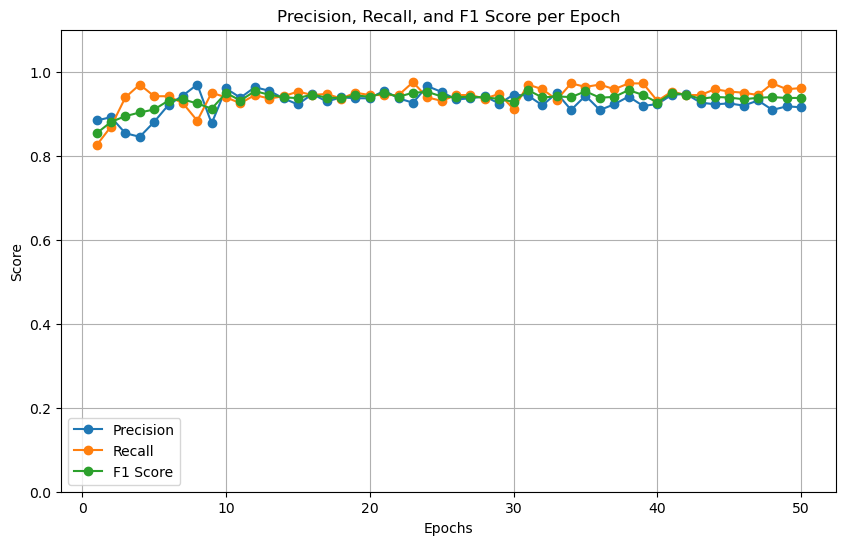

In [81]:
total_epochs = 50
val_ground_truth = np.array(val_ground_truth)
val_predicted_truth = np.array(val_predicted_truth)

valid_metrics = calculate_metrics(val_ground_truth, val_predicted_truth, total_epochs)

# Print metrics for validation data
for epoch in range(total_epochs):
    print(f"Epoch {epoch + 1} (Validation): Precision={valid_metrics['precision'][epoch]:.2f}, "
          f"Recall={valid_metrics['recall'][epoch]:.2f}, F1-Score={valid_metrics['f1_score'][epoch]:.2f}")

# Plot metrics for validation data
plot_metrics(valid_metrics, total_epochs)

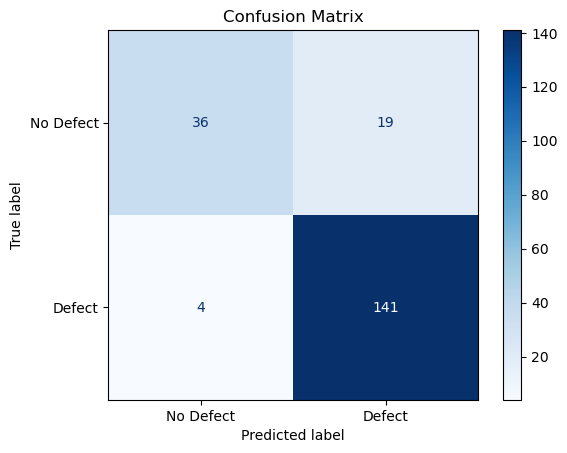

In [ ]:
# Using test data results for confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Defect", "Defect"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

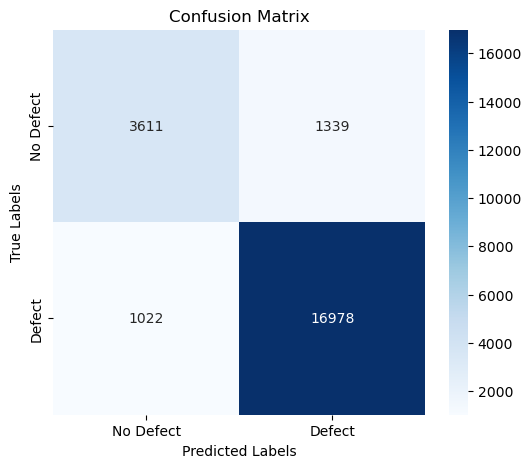

In [82]:
# Using validation data for confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming you have valid_ground_truth and valid_predicted_truth for validation

# Generate confusion matrix
cm = confusion_matrix(val_ground_truth, val_predicted_truth)

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['No Defect', 'Defect'], yticklabels=['No Defect', 'Defect'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


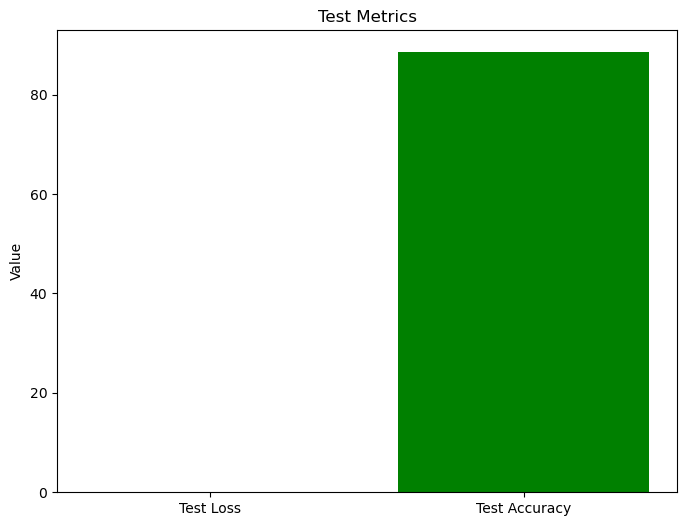

In [89]:
plt.figure(figsize=(8, 6))
metrics = ['Test Loss', 'Test Accuracy']
values = [test_results['test_loss'], test_results['test_accuracy']]

plt.bar(metrics, values, color=['blue', 'green'])
plt.title('Test Metrics')
plt.ylabel('Value')
plt.show()

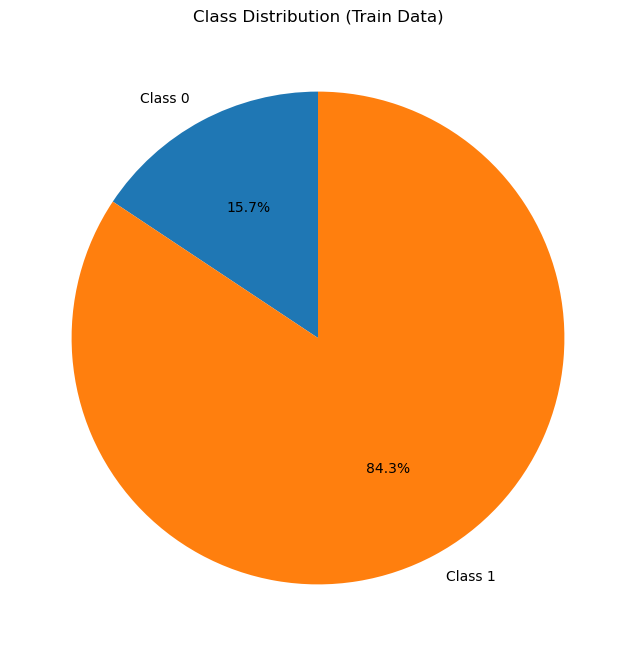

In [92]:
# Class Distribution Visualization
# A bar plot or pie chart can be used to visualize the distribution of defective vs. non-defective images in your dataset. Below is the code:

import torch
from collections import Counter
import matplotlib.pyplot as plt

# Initialize a counter for class labels
class_counter = Counter()

# Iterate through the train loader to count class occurrences
for _, labels in train_loader:  # Replace train_loader with your actual DataLoader
    class_counter.update(labels.numpy())  # Convert labels to numpy and update counter

# Convert counts to a sorted list based on class indices
class_counts = [class_counter[i] for i in range(len(class_counter))]
class_labels = [f'Class {i}' for i in range(len(class_counter))]

# Plot a pie chart for class distribution
plt.figure(figsize=(8, 8))
plt.pie(class_counts, labels=class_labels, autopct='%1.1f%%', startangle=90)
plt.title('Class Distribution (Train Data)')
plt.show()


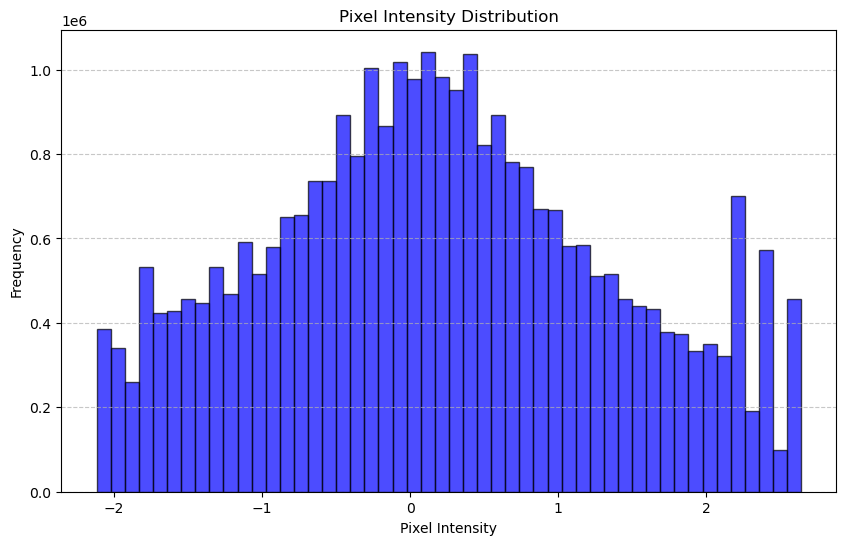

In [91]:
# Image Statistics Visualization
# You can visualize pixel intensity distributions using a histogram. This can highlight issues like low contrast or overexposure in your images


import numpy as np
import matplotlib.pyplot as plt

# Initialize an empty list to store pixel intensities
pixel_values = []

# Iterate through the train loader to extract pixel intensities
for images, _ in train_loader:  # Replace train_loader with your actual DataLoader
    images = images.numpy()  # Convert tensors to NumPy arrays
    images = images.transpose(0, 2, 3, 1)  # Rearrange dimensions to (batch, height, width, channels)
    pixel_values.extend(images.flatten())  # Flatten and append pixel values

# Convert the list of pixel values to a NumPy array
pixel_values = np.array(pixel_values)

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(pixel_values, bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.title('Pixel Intensity Distribution')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
